# Transition risk and climate risk 

> This project aims at jointly modeling physical and
transition risk within a Merton-like credit risk model, building up on [Bouchet and Le Guenedal, 2020].

<br>

**Target** : Introduce physical risk in the model as a Poisson component variable, whose
jumps are proportional to the total asset value (any alternative may be proposed). You
may consider a simpler model where physical risk occurs only once (with a exponential
law time distribution).

* Assess the additional impact of physical risk on default probabilities

# TODO - Meet with B. ROGER

## Fixer les paramètres du modèle de Merton avant pris en compte du risk climat

Composition bilan d'une entreprise 

Dette LT & Dette CT 

D Merton = Dette CT + 1/2 Dette LT

E & D = actifs totaux de la boite

-> Paramètres initiaux 

## Chercher la PD de l'entreprise

PD de l'entreprise grâce au ratings : Intuiter D1 ; D2 ; Sigma 

## Calcul de zeta 

Calculer le zeta : Quel est le coût de la taxe carbone pour ces deux entrerprises 
zeta augmente au cours du temps (GIEC & NFES) // Augmentation carbon tax *4

Boucher le guenedal  = Plusieurs scénarios 

## Modéliser une catastrophe natuelle 

Impact d'une catastrophe naturel // Pétrolier - Enérgeticien

Concentration du CO2 dans l'atmosphère 

## Implémentation technique 

Modèle poisson ; ou alors saut loi exponentielle sur l'année 

Comment évolue la PD au cours du temps ?
Avec la taxe carbone qui augmente 
Avec le risque climatique 

> Analyse de sensibilité : Qu'est-ce qui impact le plus 
Recommandations // politique

## Merton Model

Il est nécessaire d'initialiser notre modèle avec la valeur de la firme en année 0 : 

*Pour cela on récupère* :

* PD : Probabilité de défault -> Permet de déterminer N1 et N2 
* $\sigma_v$ : Déterminé grâce au cours de l'action 
* V,E,D : récupérés grâce à l'étude des comptes

In [11]:
import numpy as np 
from scipy.stats import norm

## Merton's Inputs

In [16]:
V = 100 # Asset value 
E = 50 # Equity value 
D = V-E #Debt value
T = 15 # Maturity - Horizon 2020 - 2035

## Déterminer $\sigma_v$

> On détermine $\sigma_v$

Pour faciliter on fixe $\sigma_v$

In [3]:
sigma_v = 0.2

## Passer de PD à d1 et d2

On détermine tout d'abord $d_1$ :

En année 0 : 

$$d_1 = \frac{ ln(\frac{V}{D})+ (r +\frac{1}{2}\sigma_v^2)\times T}{\sigma_v\sqrt{T}}$$

$$ DD = d_1 $$

$$PD = \Phi(-DD)$$

Avec $\Phi$ = N : Cumulated normal distribution

In [12]:
PD = 0.02 # 2% of PD

## Reverse cumulative normal distribution

In [10]:
inv_PD = norm.cdf(PD) # Inverse of cumulative normal distribution

In [7]:
inv_PD

0.5079783137169019

## Compute d1 - using PD and $\sigma_v$

$$PD = \Phi(-DD) \rightarrow d_1 = -\Phi^{-1}(PD)$$

In [8]:
d1 = -inv_PD

In [13]:
d2 = d1-sigma_v*np.sqrt(T)

In [15]:
print('d1 =',round(d1,3))
print('d2 =',round(d2,3))

d1 = -0.508
d2 = -1.603


# Introduce carbon tax

3 évolutions de prix possibles - sur l'horizon 2030-2035 (si plus changer maturité)

In [19]:
time  = [i+2020 for i in range(T+1)]

<img src= 'https://i.guim.co.uk/img/media/51937f9adf4c672d1a3e8613e53a5ad4d6fa9b77/0_0_1420_1029/master/1420.png?width=620&quality=85&auto=format&fit=max&s=b63a12d3102dcac5c8939edf758bf76f'>

Sur la base de ce graph du guardian, rédaction de 4 scénarios

In [41]:
import matplotlib.pyplot as plt

### Implement carbon scenario

In [53]:
carbon_price_dict = {25:[0.01,0.05],50:[0.01,0.05]} #Dictionnaire avec le prix de base et le rate; donné à titres indicatifs

In [73]:
### Create scenario
def create_carbon_scenarios(carbon_dict):
    ## Create a scenario based on dict : {initial_value1:[growth],initial_value2:[growth]}
    carbon_scenarios = [] # Stores all carbon scenario 
    for (i,base_value) in enumerate(carbon_dict):
        for (j,growth_rate) in enumerate(carbon_dict[base_value]):
            scenario = [base_value*(1+growth_rate)**t for t in range(T+1)]
            carbon_scenarios.append(scenario)
    return(carbon_scenarios)

### Plot scenarios
def plot_scenarios(carbon_scenarios,prefix='Carbon tax',ylabel='Carbon tax [USD]'):
    for (i,scenario) in enumerate(carbon_scenarios):
        plt.plot(time,scenario,label=f"{prefix} {i+1}")
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

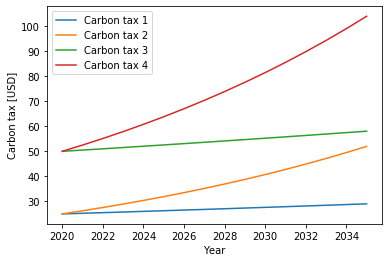

In [74]:
carbon_scenarios = create_carbon_scenarios(carbon_price_dict)
plot_scenarios(carbon_scenarios)

# Transition risk  - From carbon tax to asset devaluation

### Need to compute carbon footprint each year : 

* Sum of carbon footprint on each country of activity : i = 0; one company only

$$CC(k,t) = \sum_{j\in M} Scope_1(j,t)\times CP(j,k,t) $$

k is scenario chosen ; j a region ; t is time

* To simplify our study - Only consider one country ? 

### Shock to EBITDA 

* Firm is equal to a given multiplier times EBITDA 

$$\zeta(k,t) = \frac{CC(k,t)}{EBITDA(k=0,t=0)}$$

### Link with initial firm value 

$$V(k,t) = (1-\zeta(k,t))\times V(k=0,t=0) $$

## Ebitda & Firm value

<img src=https://chinookadvisors.com/wp-content/uploads/2020/07/figure.png>

### Compute zeta 

In [47]:
multiple = 7

## What amount of carbon dioxyde ? British Petroleum

<img src = https://safety4sea.com/wp-content/uploads/2019/02/bp-co2-in-2040-1024x517.png>

In [52]:
ebitda_0 = V/multiple
scope = 35e9 # 35 Gigatons of carbon

In [71]:
bp_dict = {35e9:[0.01,-0.03,-0.079]}

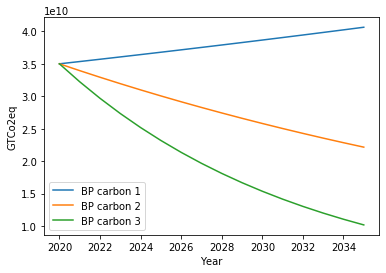

In [75]:
bp_carbon_scenarios = create_carbon_scenarios(bp_dict)
plot_scenarios(bp_carbon_scenarios,prefix='BP carbon',ylabel='GTCo2eq')

### Quelques remarques

* A quoi ça sert de calculer à l'année 0 les paramètres du model de merton ? 
* Juste besoin de la probabilité de défaut initiale ; et de V0

<br>
-> on calcule V0 